# Schrödinger's Python

<img src="https://github.com/natsunoyuki/blog_posts/blob/main/images/schrodinger_eq_1d.png?raw=True" alt="drawing" width="333"/>

When one talks about <a href="https://en.wikipedia.org/wiki/Quantum_mechanics" target="_blank">quantum mechanics</a>, the animal one usually associates with the subject is the <a href="https://en.wikipedia.org/wiki/Schrödinger%27s_cat" target="_blank">cat</a>. Unfortunately there is no programming language I know of named "Cat" (there should be!), so today's post will have to make do with the title "Schrödinger's Python". Yes I know, snakes are usually not associated with quantum physics. So why Python you might ask? Well, because we will be using Python in this post to numerically solve the time independent <a href="https://en.wikipedia.org/wiki/Schrödinger_equation" target="_blank">Schrödinger equation</a> shown above!

The main aim of this post is not to teach you quantum physics, but how to use Python programming to numerically solve complex physics problems. I will put some links below at the bottom which you can refer to if you would like to know more! 

## The Time Independent Schrödinger Equation

The time independent <a href="https://en.wikipedia.org/wiki/Schrödinger_equation" target="_blank">Schrödinger equation</a> is an <a href="https://en.wikipedia.org/wiki/Eigenvalues_and_eigenvectors" target="_blank">eigenvalue</a> problem. This means that it can be cast in matrix form as: __HΨ = EΨ__, where __H__ is the <a href="https://en.wikipedia.org/wiki/Hamiltonian_(quantum_mechanics)" target="_blank">Hamiltonian</a> matrix (the <a href="https://en.wikipedia.org/wiki/Hamiltonian_mechanics#Mathematical_formalism" target="_blank">Hamiltonian</a> is essentially the sum of a particle's kinetic and potential energies), __Ψ__ is the wave function vector and _E_ is the energy eigenvalue. For the less mathematically inclined, this relation simply means that multiplying matrix __H__ on vector __Ψ__ gives the same result as multiplying the scalar value _E_ on vector __Ψ__. Physically this means that operating the Hamiltonian which is the sum of kinetic and potential energies returns the total energy of the particle!

Therefore, if we can determine the form of the matrix __H__, we can then numerically solve the system to get the both quantum mechanical wave function __Ψ__, as well as the corresponding total particle energy _E_.

As can be seen in the equation at the top of this post, the matrix __H__ is the sum of a second order derivative (physically this is the kinetic energy) and the potential energy  _V_. For simplicity's sake, we will assume that the Planck constant _ħ_ and particle mass _m_ are both equal to 1. Also for this post we will solve the Schrödinger equation numerically for 1 dimension only. Higher dimensions will be treated next time!

## Discretizing the 1D Schrödinger Equation

The first step is to determine how to implement the derivative numerically. By using second order central finite differences for 1 dimension, the wave function is differentiated numerically as: -1/(2dx<sup>2</sup>)[Ψ<sub>n-1</sub> - 2Ψ<sub>n</sub> + Ψ<sub>n+1</sub>] as can be seen in the discretised equation below. Note that we have set _ħ_ = _m_ = 1 for simplicity's sake, and that dx is the step size of the spatial grid used.

<img src="https://github.com/natsunoyuki/blog_posts/blob/main/images/schrodinger_eq_1d_a.png?raw=True" alt="drawing" width="333"/>

Therefore if we scale the values of _V_ and _E_ by a factor of 2, the Hamiltonian matrix __H__ takes the form of a tridiagonal matrix with 2/dx<sup>2</sup> in the main diagonal, and -1/dx<sup>2</sup> in the first diagonals above and below the main diagonal. We then add to this the potential energy _V_ to complete the Hamiltonian matrix __H__.

Note that setting up the Hamiltonian matrix in such a manner results in <a href="https://en.wikipedia.org/wiki/Dirichlet_boundary_condition" target="_blank">Dirichlet boundary conditions</a> being intrinsically applied to the numerical system. This should work for most situations in general, but might break down for situations which require other forms of boundary conditions such as <a href="https://en.wikipedia.org/wiki/Periodic_boundary_conditions" target="_blank">periodic boundary conditions</a>. 

Instead of using standard linear algebra libraries, we use the <a href="https://docs.scipy.org/doc/scipy/reference/sparse.html">sparse matrix linear algebra library</a>. This is because the Hamiltonian matrix __H__ is composed mainly of 0s (i.e. the matrix is sparse), and using the sparse matrix libraries will help to speed up computation for extremely large systems. Also using the sparse matrix eigenvalue calculators allow us to control the number of solutions to find, rather than calculating every single possible solution which will take a lot of time and resources.

After constructing __H__ we then calculate its eigenvectors and eigenvalues using  `[evl, evt] = sla.eigs(H, k=neigs, which='SM')`. We choose the number of solutions to obtain by setting the value of `k=neigs`. We also choose to obtain the smallest magnitude solutions with `which='SM'`. We then normalise the eigenvectors at the end. The code to construct __H__ and calculate its eigenvectors and eigenvalues is presented below. Note that the function `schrodinger1D` has the following arguments: `xmin =  minimum x grid value`,  `xmax = maximum x grid value`,  `Nx = number of grid points`, `Vfun = potential energy function`, `neigs = number of eigenvalues to solve for`, and `findpsi = flag` to determine what the function returns.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import sparse
from scipy.sparse import linalg as sla

def schrodinger1D(xmin, xmax, Nx, Vfun, params, neigs=20, findpsi=False):
    x = np.linspace(xmin, xmax, Nx)  # x axis grid
    dx = x[1] - x[0]  # x axis step size
    # Obtain the potential function values:
    V = Vfun(x, params)
    # create the Hamiltonian Operator matrix:
    H = sparse.eye(Nx, Nx, format='lil') * 2
    # implement the numerical derivative
    for i in range(Nx - 1):
        H[i, i + 1] = -1
        H[i + 1, i] = -1
    H = H / (dx ** 2)
    # Add in the potential energy
    for i in range(Nx):
        H[i, i] = H[i, i] + V[i]
    # convert to csc matrix format
    H = H.tocsc()
    # obtain neigs solutions from the sparse matrix
    [evl, evt] = sla.eigs(H, k=neigs, which='SM')
    for i in range(neigs):
        # normalize the eigen vectors
        evt[:, i] = evt[:, i] / np.sqrt(
                                np.trapz(np.conj(
                                evt[:,i])*evt[:,i],x))
        # eigen values MUST be real:
        evl = np.real(evl)
    if findpsi == False:
        return evl
    else: 
        return evl, evt, x

## The Quantum Harmonic Oscillator

Now that we have the functionality to solve the 1 dimensional Schrödinger equation numerically, all we need to do is to give it something to solve by specifying the potential energy `Vfun`! For the first example we will explore the <a href="https://en.wikipedia.org/wiki/Quantum_harmonic_oscillator" target="_blank">quantum simple harmonic oscillator</a>.

The quantum simple harmonic oscillator has a potential energy function given by _V_ = _kx_<sup>2</sup> where _k_ is the "spring constant". To simplify matters we set _k_ = 1, therefore _V_ = _x_<sup>2</sup>. We then pass this potential energy function to the solver above to solve for the eigenvalues and eigenvectors. The theoretical eigen-energies of the quantum harmonic oscillator are given by _E_ = _ħω_(_n_ + 1/2). In our case we set _ħ_ = _ω_ = 1, and remember that we scaled the energies by a factor of 2 in our numerical differentiation scheme, so the adjusted theoretical eigen-energies take the form _E_ = 2<i>n</i> + 1.

In [2]:
def sho_wavefunctions_plot(xmin = -10, xmax = 10, Nx = 500, neigs = 20, params = [1]):
    
    def Vfun(x, params):
        V = params[0] * x**2
        return V
    
    eval_wavefunctions(xmin, xmax, Nx, Vfun,
                       params, neigs, True)

The solver `schrodinger1D` is called by the function `eval_wavefunctions` whose code is shown below.  The function then calculates the probability of the particle existing at some particular grid point from the wave functions, and plots the probabilities. Also as a sanity check, we print the eigenvalues sorted in ascending magnitude!

In [3]:
def eval_wavefunctions(xmin, xmax, Nx, Vfun, params, neigs, findpsi = True):
    # call the 1D Schrodinger solver:
    H = schrodinger1D(xmin, xmax, Nx, Vfun, params, neigs, findpsi)
    evl = H[0] # energy eigenvalues
    indices = np.argsort(evl)
    print("Energy eigenvalues:")
    for i,j in enumerate(evl[indices]):
        print("{}: {:.2f}".format(i+1,j))
    evt = H[1] # eigenvectors 
    x = H[2] # x grid 
    i = 0
    plt.figure(figsize=(8,8))
    while i < neigs:
        n = indices[i]
        # obtain probabilities from wave functions
        y = np.real(np.conj(evt[:, n]) * evt[:, n])  
        plt.subplot(neigs, 1, i+1)  
        plt.plot(x, y)
        plt.axis('off')
        i = i + 1  
    plt.show()

Running the function `sho_wavefunctions_plot` plots the first 20 probabilities for the quantum harmonic oscillator shown below in order of increasing energy states! We see that for the lowest energy level at the top of the plot, the particle is most likely to be found at the centre of the potential well where the potential energy is the lowest. As energy increases, the particle is able to move up to regions of higher potential energy on both sides of the centre of the well, hence the probability of it being found at other locations increases!

Energy eigenvalues:
1: 1.00
2: 3.00
3: 5.00
4: 7.00
5: 9.00
6: 10.99
7: 12.99
8: 14.99
9: 16.99
10: 18.98
11: 20.98
12: 22.97
13: 24.97
14: 26.96
15: 28.96
16: 30.95
17: 32.95
18: 34.94
19: 36.93
20: 38.92


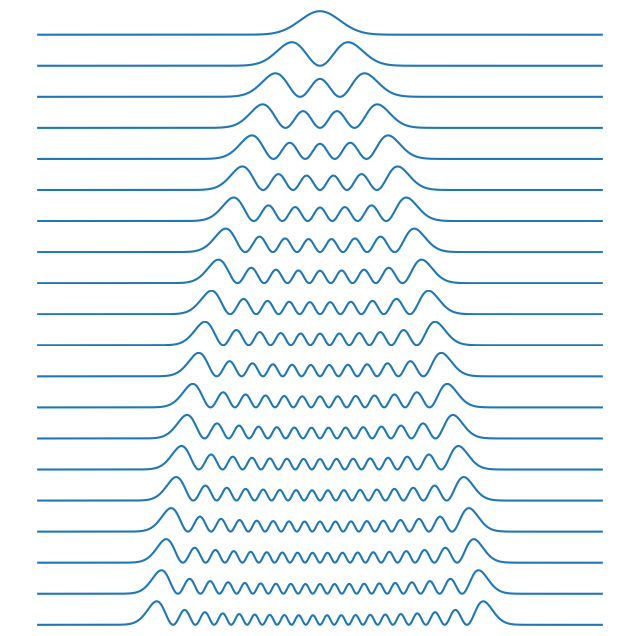

In [4]:
sho_wavefunctions_plot()

Also, the numerically calculated eigen-energies for the 20 discrete energy levels _n_ turn out to match the theoretical values given by _E_ = 2<i>n</i> + 1 very closely especially for the smaller values of _n_, so we know our Schrödinger equation solver has worked!

This concludes how to solve the Schrödinger equation numerically for 1 spatial dimension. Unfortunately, 1 dimensional systems are usually not too realistic, and we need to get to at least 2 dimensions in order to simulate physical systems realistically. Luckily I have another post showing how to solve the Schrödinger equation numerically in <a href="https://github.com/natsunoyuki/blog_posts/blob/main/physics/Schrödinger's%20Python%202.ipynb" target="_blank">2 dimensions</a>!

***

Github Repository
The full 1D Schrödinger equation solver code can be found in my <a href="https://github.com/natsunoyuki/Computational_Physics_in_Python/blob/master/schrodinger1D.py" target="_blank">Github repository</a>.

More computational physics projects and codes can be found in my Github repository:
https://github.com/natsunoyuki/Computational_Physics_in_Python

***

## My recommended books to learn more about Quantum Mechanics:
(I am in no way related or affiliated to the links provided!)

* <a href="https://www.amazon.com/Introduction-Quantum-Mechanics-David-Griffiths/dp/1107179866" target="_blank">Introduction to Quantum Mechanics</a>, D. J. Griffiths - this book is a great book for those who do not have an advanced physics background. Also this book has a picture of a cat on the cover!

* <a href="https://www.amazon.com/Quantum-Mechanics-2nd-B-H-Bransden/dp/0582356911" target="_blank">Quantum Mechanics</a>, B. H. Bransden and C. J. Joachain - for the more advanced people, I would recommend this introductory book which is more thorough and detailed mathematically. Unfortunately no cats on the cover.